In [2]:
# Importing necessary libraries and downloading NLTK resources
import re, nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
import numpy as np
import pandas as pd
# Imblearn library can be installed using pip install imblearn
from imblearn.over_sampling import SMOTE      # Importing SMOTE for oversampling the imbalanced dataset
from bs4 import BeautifulSoup     # Importing BeautifulSoup for HTML parsing
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import joblib


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240550 entries, 0 to 240549
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        240550 non-null  int64 
 1   app_name      240550 non-null  object
 2   review_text   240550 non-null  object
 3   review_score  240550 non-null  int64 
 4   review_votes  240550 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 9.2+ MB


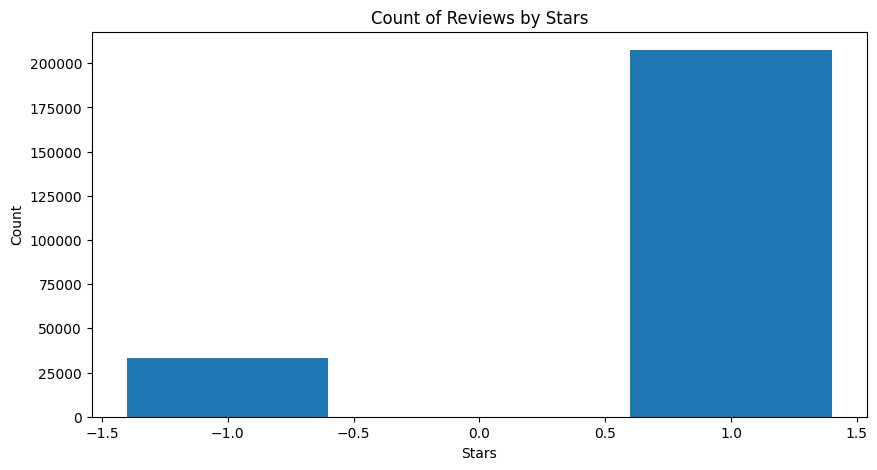

In [3]:
# Reading dataset as dataframe
df = pd.read_csv("C:/Users/hp/Desktop/Code/train data 6 games.csv")
pd.set_option('display.max_colwidth', None) # Setting this so we can see the full content of cells
pd.set_option('display.max_columns', None) # To make sure we can see all the columns in output window
df.info() # Displaying information about the dataset

# Plotting simple bar graph to know the count of reveiews by stars
import matplotlib.pyplot as plt

ratings_count = df['review_score'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(ratings_count.index, ratings_count.values)
plt.title('Count of Reviews by Stars')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()



In [4]:
def cleaner(review): # Cleaning reviews
    soup = BeautifulSoup(review, 'lxml') # removing HTML entities such as ‘&amp’,’&quot’,'&gt'; lxml is the html parser and shoulp be installed using 'pip install lxml'
    souped = soup.get_text()
    re1 = re.sub(r"(@|http://|https://|www|\\x)\S*", " ", souped) # substituting @mentions, urls, etc with whitespace
    re2 = re.sub("[^A-Za-z]+"," ", re1) # substituting any non-alphabetic character that repeats one or more times with whitespace

    tokens = nltk.word_tokenize(re2)
    lower_case = [t.lower() for t in tokens]

    stop_words = set(stopwords.words('english'))
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [5]:
df['cleaned_review'] = df['review_text'].apply(cleaner)
df = df[df['cleaned_review'].map(len) > 0] # removing rows with cleaned reviews of length 0
print("Printing top 5 rows of dataframe showing original and cleaned reviews....")
print(df[['review_text','cleaned_review']].head())
df['cleaned_review'] = [" ".join(row) for row in df['cleaned_review'].values] # joining tokens to create strings. TfidfVectorizer does not accept tokens as input
data = df['cleaned_review']
Y = df['review_score'] # target column
tfidf = TfidfVectorizer(min_df=.00086, ngram_range=(1,3)) # min_df=.00086 means that each ngram (unigram, bigram, & trigram) must be present in at least 20 documents for it to be considered as a token (23305*.00086=20). This is a clever way of feature engineering
tfidf.fit(data) # learn vocabulary of entire data
data_tfidf = tfidf.transform(data) # creating tfidf values
pd.DataFrame(pd.Series(tfidf.get_feature_names_out())).to_csv('vocabulary_steamreviews.csv', header=False, index=False)
print("Shape of tfidf matrix: ", data_tfidf.shape)

C:\Users\hp\AppData\Local\Temp\ipykernel_31596\3214502770.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(review, 'lxml') # removing HTML entities such as ‘&amp’,’&quot’,'&gt'; lxml is the html parser and shoulp be installed using 'pip install lxml'


Printing top 5 rows of dataframe showing original and cleaned reviews....
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      review_text  \
0  You can be a werewolf riding a unicorn while shooting rainbows from a 

In [6]:
# Implementing Support Vector Classifier
model1 = LinearSVC() # kernel = 'linear' and C = 1

# Running cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # 10-fold cross-validation
scores=[]
iteration = 0
smote = SMOTE(random_state = 101)
for train_index, test_index in kf.split(data_tfidf, Y):
    iteration += 1
    print("Iteration ", iteration)
    # Resetting index of Y to ensure it aligns with the indices generated by kf.split
    Y_reset = Y.reset_index(drop=True)
    X_train, Y_train = data_tfidf[train_index], Y_reset[train_index]
    X_test, Y_test = data_tfidf[test_index], Y_reset[test_index]
    X_train,Y_train = smote.fit_resample(X_train,Y_train) # Balancing training data
    model1.fit(X_train, Y_train) # Fitting SVC
    Y_pred = model1.predict(X_test)
    score = metrics.precision_score(Y_test, Y_pred) # Calculating precision
    print("Cross-validation precison: ", score)
    scores.append(score) # appending cross-validation precision for each iteration
mean_precision = np.mean(scores)
print("Mean cross-validation precision: ", mean_precision)

Iteration  1
Cross-validation precison:  0.9701268804539858
Iteration  2
Cross-validation precison:  0.969599312493286
Iteration  3
Cross-validation precison:  0.9707495429616088
Iteration  4
Cross-validation precison:  0.9719782292396401
Iteration  5
Cross-validation precison:  0.9699757869249395
Iteration  6
Cross-validation precison:  0.971284418442381
Iteration  7
Cross-validation precison:  0.9694125262987539
Iteration  8
Cross-validation precison:  0.9702374556785215
Iteration  9
Cross-validation precison:  0.9704205657739056
Iteration  10
Cross-validation precison:  0.9728140676411888
Mean cross-validation precision:  0.9706598785908209


In [7]:
# Implementing Naive Bayes Classifier
model2 = MultinomialNB()

# Running cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # 10-fold cross-validation
scores=[]
iteration = 0
smote = SMOTE(random_state = 101)
for train_index, test_index in kf.split(data_tfidf, Y):
    iteration += 1
    print("Iteration ", iteration)
    # Resetting index of Y to ensure it aligns with the indices generated by kf.split
    Y_reset = Y.reset_index(drop=True)  # Reset index for each iteration
    X_train, Y_train = data_tfidf[train_index], Y_reset[train_index]  # Use Y_reset
    X_test, Y_test = data_tfidf[test_index], Y_reset[test_index]    # Use Y_reset
    X_train,Y_train = smote.fit_resample(X_train,Y_train) # Balancing training data
    model2.fit(X_train, Y_train) # Fitting NBC
    Y_pred = model2.predict(X_test)
    score = metrics.precision_score(Y_test, Y_pred) # Calculating precision
    print("Cross-validation precison: ", score)
    scores.append(score) # appending cross-validation precision for each iteration
mean_precision = np.mean(scores)
print("Mean cross-validation precision: ", mean_precision)

Iteration  1
Cross-validation precison:  0.9746077507346012
Iteration  2
Cross-validation precison:  0.9739193163531435
Iteration  3
Cross-validation precison:  0.9749277295975094
Iteration  4
Cross-validation precison:  0.975890868596882
Iteration  5
Cross-validation precison:  0.9739265505381116
Iteration  6
Cross-validation precison:  0.9757854491051144
Iteration  7
Cross-validation precison:  0.9730620913206282
Iteration  8
Cross-validation precison:  0.9749806265913872
Iteration  9
Cross-validation precison:  0.9742620490299627
Iteration  10
Cross-validation precison:  0.975867269984917
Mean cross-validation precision:  0.9747229701852257


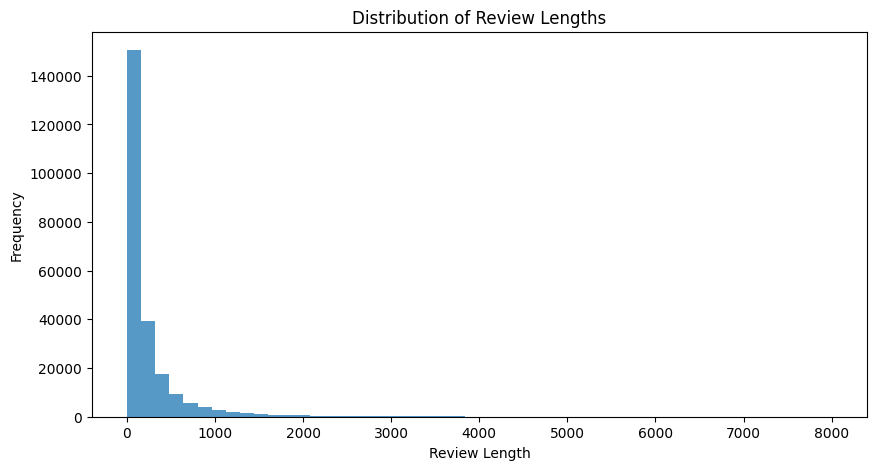

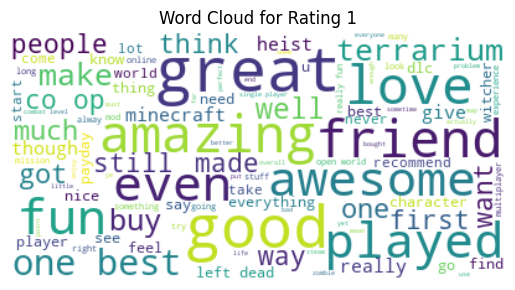

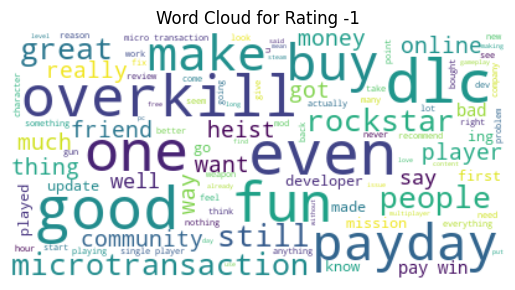

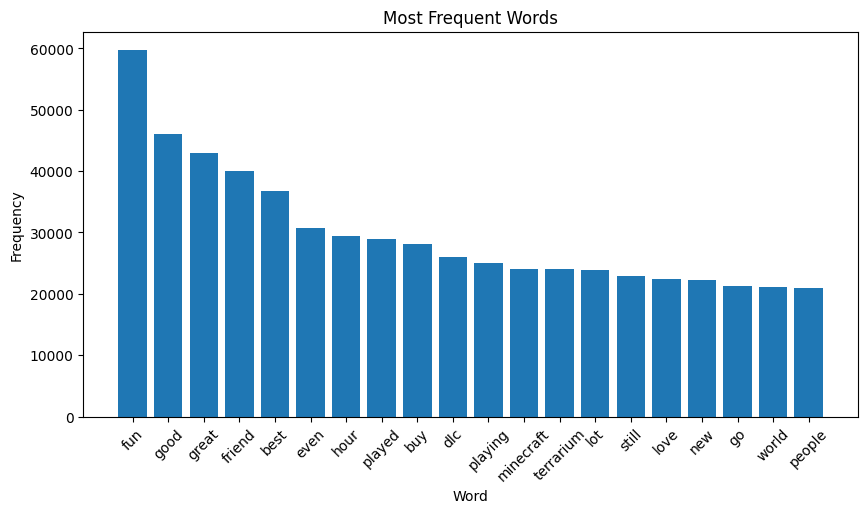

In [18]:
# Additional Visualizations and Data Exploration

# 1. Distribution of Review Lengths

df['review_length'] = df['review_text'].apply(len)

plt.figure(figsize=(10, 5))
plt.hist(df['review_length'], bins=50, alpha=0.75)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# 2. Word Clouds for Different Ratings (with word removal)

from wordcloud import WordCloud, STOPWORDS

# Add words you want to exclude to the STOPWORDS set
stop_words_to_remove = {'game', 'play', 'time'} 
STOPWORDS.update(stop_words_to_remove)

for rating in df['review_score'].unique():
    subset = df[df['review_score'] == rating]
    text = " ".join(subset['cleaned_review'])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=STOPWORDS).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

    plt.title(f"Word Cloud for Rating {rating}")
    plt.show()

# 3. Most Frequent Words (with word removal)

from collections import Counter

all_words = [word for review in df['cleaned_review'] for word in review.split()]
word_counts = Counter(all_words)

# Remove unwanted words from the word counts
words_to_remove = {'game', 'play', 'time','get', 'one', 'like', 'really', 'would', 'much', 'make', 'ever', 'thing'}
for word in words_to_remove:
    del word_counts[word]

most_common_words = word_counts.most_common(20)

plt.figure(figsize=(10, 5))
plt.bar(*zip(*most_common_words))
plt.xticks(rotation=45)
plt.title('Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()